# Chapter 07 - Feature Engineering and AutoML

Code for the O'Reilly Book - Practical Automated Machine Learning on Azure
by Deepak Mukunthu, Parashar Shah & Wee Hyong Tok

In [1]:
# check the version of AzureML SDK
# Note: Always good practice to check the version of AzureML SDK used in the notebook environment
# AzureML SDK should be 1.0.43 or greater
import azureml.core
print(azureml.core.VERSION)

1.0.43


## 01 - Acquire and Prepare Data
For this notebook, we will use the NASA Prognostics Center's Turbo-Fan Failure dataset.  It is located here: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

We have it as .txt file in the same folder. We read it into a Pandas DataFrame.
Note the headers were not in the space seperated txt file, so we assign them from the ReadMe in the zip file. In pandas we use read_csv with the delimiter option, even with a space delimited file.

In [8]:
# Download the NASA Turbofan Engine Degradation Simulation Data Set
import requests, zipfile, io

nasa_dataset_url = "https://ti.arc.nasa.gov/c/6/"
r = requests.get(nasa_dataset_url)

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/")

In [9]:
import pandas as pd
train = pd.read_csv("data/train_FD004.txt", delimiter="\s|\s\s", index_col=False, engine='python', 
                    names=['unit','cycle','os1','os2','os3','sm1','sm2','sm3','sm4','sm5','sm6','sm7','sm8','sm9','sm10',
                           'sm11','sm12','sm13','sm14','sm15','sm16','sm17','sm18','sm19','sm20','sm21'])

Let's explore the data

In [10]:
train.head(5)

,unit,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm12,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


Our dataset has a number of units in it, with each engine flight listed as a cycle. The cycles count up until the engine fails. What we would like to predict is the no. of cycles until failure. 
So we need to calculate a new column called RUL, or Remaining Useful Life.  It will be the last cycle value minus each cycle value per unit.

In [11]:
# Assign ground truth
def assignrul(df):
    maxi = df['cycle'].max()
    df['rul'] = maxi - df['cycle']
    return df
    

train_new = train.groupby('unit').apply(assignrul)

train_new.columns

Index(['unit', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5',
       'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14',
       'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21', 'rul'],
      dtype='object')

Now our dataframe has the 'RUL' column.  Predicting this value will be the objective of this exercise.

In [12]:
train_new.head(5)

,unit,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,rul
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


First note that the sensor measurements do seem to be changing as we near 0 RUL. This implies that we should be able to make a model that will be useful enough for business value.

We are now ready to train a model on this data using Automated ML.

In [13]:
# put training data into X and Y arrays
X_train = train_new.iloc[:,2:26].values
y_train = train_new.iloc[:,26:27].values.astype(int).flatten()

In [14]:
# Split the dataset to train and test
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.3,
                                                    random_state=100)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                    y_valid,
                                                    test_size=0.3,
                                                    random_state=100)

X_train = pd.DataFrame(X_train)
X_valid = pd.DataFrame(X_valid)
X_test = pd.DataFrame(X_test)

## 02 - Prepare the Azure Machine Learning Workspace

Import Azure ML libs for automated ML

In [16]:
import logging
import os
import random
import time

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd


In [17]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.widgets import RunDetails
from azureml.core.model import Model

Provide your Machine Learning Workspace credentials to run AutoML. You will need to perform Microsoft's MFA. Please follow the manual auth instructions.

In [18]:
#subscription_id = "<Your SubscriptionId>" #you should be owner or contributor
#resource_group = "<Resource group - new or existing>" #you should be owner or contributor
#workspace_name = "<workspace to be created>" #your workspace name
#workspace_region = "<azureregion>" #your region

In [19]:
# Subscription ID
subscription_id = "<Your SubscriptionId>" #you should be owner or contributor
resource_group = "automl_nasa_newrg" #you should be owner or contributor
workspace_name = "automatedml_nasa_aznb_ch07" #your workspace name
workspace_region = "West US 2" #your region

Create Azure ML workspace

In [ ]:
# Import the Workspace class and check the Azure ML SDK version.
from azureml.core import Workspace

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,                      
                      exist_ok=True)
ws.get_details()

Write config to cluster

In [21]:
from azureml.core import Workspace

ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

Define the experiment name

In [ ]:
# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-predictive-rul-ch07'
project_folder = './ch07_projects/automl-feature-engineering'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Enable Telemetry

In [23]:
from azureml.telemetry import set_diagnostics_collection

In [24]:
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on. 


Now we are ready to configure automated ML.  

We provide necessary information on: what we want to predict, what accuracy metric we want to use, how many models we want to try, and many other parameters.  
AutoML will also automatically scale the data for us.

## 03 - Auto Featurization with Automated ML

You can use these params.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|
|**preprocess**|set this to True to enable pre-processing of data eg. string to numeric using one-hot encoding|
|**exit_score**|Target score for experiment. It is associated with the metric. eg. exit_score=0.995 will exit experiment after that|

In [41]:
from pprint import pprint

def print_model(model, prefix=""):
    for step in model.steps:
        print(prefix + step[0])
        if hasattr(step[1], 'estimators') and hasattr(step[1], 'weights'):
            pprint({'estimators': list(e[0] for e in step[1].estimators), 'weights': step[1].weights})
            print()
            for estimator in step[1].estimators:
                print_model(estimator[1], estimator[0]+ ' - ')
        elif hasattr(step[1], '_base_learners') and hasattr(step[1], '_meta_learner'):
            print("\nMeta Learner")
            pprint(step[1]._meta_learner)
            print()
            for estimator in step[1]._base_learners:
                print_model(estimator[1], estimator[0]+ ' - ')
        else:
            pprint(step[1].get_params())
            print()

In [26]:
from pprint import pprint
import pandas as pd

# function to pretty print the engineered features
def print_engineered_features(features_summary):
    print(pd.DataFrame(features_summary, columns=["RawFeatureName", "TypeDetected", "Dropped","EngineeredFeatureCount","Tranformations"]))

In [27]:
#model_explainability=True,

### 3a - Auto Featurization with AutoML using NASA Dataset

In [28]:
import time

automl_settings = {
    "name": "AutoML_Book_CH07_FeatureEngineering_{0}".format(time.time()),
    "task": "regression",
    "iteration_timeout_minutes": 10,
    "iterations": 10,
    "max_cores_per_iteration": 1,
    "primary_metric": 'r2_score',
    "max_concurrent_iterations": 10,
    "experiment_exit_score": 0.985,
    "debug_log": "automl_ch07_errors{0}.log".format(time.time()),
    "verbosity": logging.ERROR
}

In [29]:
##Local compute 
Automl_config = AutoMLConfig(
                             preprocess = False,
                             X = X_train,
                             y = y_train,
                             X_valid = X_valid,
                             y_valid = y_valid,
                             path=project_folder,
                             **automl_settings)

In [30]:
# Training the predictive maintenance model
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_d926caf4-6af4-4956-bb4e-46b58e595e81
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper LightGBM                 0:00:15       0.6161    0.6161
         1   MaxAbsScaler LightGBM                          0:00:19       0.6186    0.6186
         2   StandardScalerWrapper ExtremeRandomTrees       0:00:12       0.4343    0.6186
         3   RobustScaler LightG

In [31]:
# find the run with the highest r2_score value.
best_run, fitted_model = local_run.get_output()

In [32]:
print(best_run)

Run(Experiment: automl-predictive-rul-ch07,
Id: AutoML_d926caf4-6af4-4956-bb4e-46b58e595e81_9,
Type: None,
Status: Completed)


In [37]:
print(fitted_model.steps)

[('stackensembleregressor', StackEnsembleRegressor(base_learners=[('5', RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f07c3507da0>), ('LightGBMRegressor', <automl.client.core.common.model_wrappers.LightGBMRegressor object at 0x7f07c....core.common.model_wrappers.LightGBMRegressor object at 0x7f07c19070f0>)]),
          stddev=None))],
            meta_learner=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
            training_cv_folds=5))]


In [42]:
print_model(fitted_model)

stackensembleregressor

Meta Learner
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

5 - StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': True,
 'with_std': True}

5 - LightGBMRegressor
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5,
 'importance_type': 'split',
 'learning_rate': 0.1789484210526316,
 'max_bin': 255,
 'max_depth': 9,
 'min_child_samples': 194,
 'min_child_weight': 0.001,
 'min_split_gain': 0.9473684210526315,
 'n_estimators': 100,
 'n_jobs': 1,
 'num_leaves': 127,
 'objective': None,
 'random_state': None,
 'reg_alpha': 1.125,
 'reg_lambda': 0.75,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

1 - MaxAbsScaler
{'copy': True}

1 - LightGBMReg

Let's explore models from Iteration 4 and 5

#### Explore the runs and models from different iterations

In [44]:
explore_run1, explore_model1 = local_run.get_output(iteration = 4)
explore_run2, explore_model2 = local_run.get_output(iteration = 5)


In [46]:
print_model(explore_model1)

StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': False,
 'with_std': True}

LightGBMRegressor
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7000000000000001,
 'importance_type': 'split',
 'learning_rate': 0.1894742105263158,
 'max_bin': 7,
 'max_depth': 3,
 'min_child_samples': 139,
 'min_child_weight': 0.001,
 'min_split_gain': 0.9473684210526315,
 'n_estimators': 800,
 'n_jobs': 1,
 'num_leaves': 7,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.075,
 'reg_lambda': 0.6,
 'silent': True,
 'subsample': 0.7999999999999999,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}



In [47]:
print_model(explore_model2)

StandardScalerWrapper
{'class_name': 'StandardScaler',
 'copy': True,
 'module_name': 'sklearn.preprocessing.data',
 'with_mean': True,
 'with_std': True}

LightGBMRegressor
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5,
 'importance_type': 'split',
 'learning_rate': 0.1789484210526316,
 'max_bin': 255,
 'max_depth': 9,
 'min_child_samples': 194,
 'min_child_weight': 0.001,
 'min_split_gain': 0.9473684210526315,
 'n_estimators': 100,
 'n_jobs': 1,
 'num_leaves': 127,
 'objective': None,
 'random_state': None,
 'reg_alpha': 1.125,
 'reg_lambda': 0.75,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}



#### What if we turn on preprocess?

In [48]:
import time

automl_settings = {
    "name": "AutoML_Book_CH07_FeatureEngineering_{0}".format(time.time()),
    "task": "regression",
    "iteration_timeout_minutes": 10,
    "iterations": 10,
    "max_cores_per_iteration": 1,
    "primary_metric": 'r2_score',
    "max_concurrent_iterations": 10,
    "experiment_exit_score": 0.985,
    "debug_log": "automl_ch07_errors{0}.log".format(time.time()),
    "verbosity": logging.ERROR
}

In [49]:
##Local compute 
Automl_config = AutoMLConfig(
                             preprocess = True,
                             X = X_train,
                             y = y_train,
                             X_valid = X_valid,
                             y_valid = y_valid,
                             path=project_folder,
                             **automl_settings)

In [50]:
# Training the predictive maintenance model
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_5ec52583-ead6-4d78-a558-0871d2b0f4e8
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper LightG

In [51]:
best_run, fitted_model = local_run.get_output()

In [52]:
fitted_model.named_steps['datatransformer']. get_engineered_feature_names ()

['C1_MeanImputer',
 'C2_MeanImputer',
 'C3_MeanImputer',
 'C4_MeanImputer',
 'C5_MeanImputer',
 'C6_MeanImputer',
 'C7_MeanImputer',
 'C8_MeanImputer',
 'C9_MeanImputer',
 'C10_MeanImputer',
 'C11_MeanImputer',
 'C12_MeanImputer',
 'C13_MeanImputer',
 'C14_MeanImputer',
 'C15_MeanImputer',
 'C16_MeanImputer',
 'C17_MeanImputer',
 'C18_MeanImputer',
 'C19_MeanImputer',
 'C20_MeanImputer',
 'C21_MeanImputer',
 'C22_MeanImputer',
 'C23_MeanImputer',
 'C24_MeanImputer']

In [53]:
# Get the summary of the engineered features
features_summary = fitted_model.named_steps['datatransformer'].get_featurization_summary()

In [54]:
# Show all the Engineered Features from AutoML auto-featurization
print_engineered_features(features_summary)

   RawFeatureName TypeDetected Dropped  EngineeredFeatureCount Tranformations
0   C1             Numeric      No      1                       [MeanImputer]
1   C2             Numeric      No      1                       [MeanImputer]
2   C3             Numeric      No      1                       [MeanImputer]
3   C4             Numeric      No      1                       [MeanImputer]
4   C5             Numeric      No      1                       [MeanImputer]
5   C6             Numeric      No      1                       [MeanImputer]
6   C7             Numeric      No      1                       [MeanImputer]
7   C8             Numeric      No      1                       [MeanImputer]
8   C9             Numeric      No      1                       [MeanImputer]
9   C10            Numeric      No      1                       [MeanImputer]
10  C11            Numeric      No      1                       [MeanImputer]
11  C12            Numeric      No      1                       

### 3b Auto Featurization with AutoML - Energy Demand Dataset

In [55]:
# Download the data for energy demand forecasting 
import requests, zipfile, io

nyc_energy_data_url = "https://raw.githubusercontent.com/Azure/MachineLearningNotebooks/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/nyc_energy.csv"
r = requests.get(nyc_energy_data_url)
open('data/nyc_energy.csv', 'wb').write(r.content)

1867062

In [56]:
data = pd.read_csv('data/nyc_energy.csv', parse_dates=['timeStamp'])
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


In [57]:
# let's take note of what columns means what in the data
time_column_name = 'timeStamp'
target_column_name = 'demand'

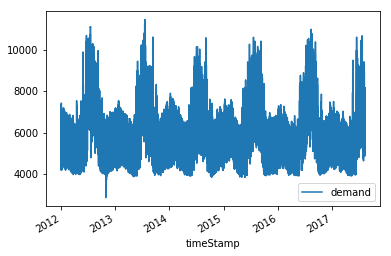

In [58]:
import matplotlib.pyplot as plt

ax = plt.gca()
data.plot(kind='line',x=time_column_name,y=target_column_name,ax=ax)
plt.show()

In [59]:
X_train = data[data[time_column_name] < '2017-02-01']
X_test = data[data[time_column_name] >= '2017-02-01']
y_train = X_train.pop(target_column_name).values
y_test = X_test.pop(target_column_name).values

In [60]:
X_train.tail(5)

,timeStamp,precip,temp
49143,2016-06-20 20:00:00,0.00,76.86
49144,2016-06-20 21:00:00,0.00,77.31
49145,2016-08-09 03:00:00,0.00,72.66
49146,2016-10-19 05:00:00,0.00,69.37
49147,2017-01-09 15:00:00,0.00,22.63


In [61]:
X_test.tail(5)

,timeStamp,precip,temp
49200,2017-08-12 02:00:00,0.00,70.84
49201,2017-08-12 03:00:00,0.00,70.57
49202,2017-08-12 04:00:00,0.00,69.89
49203,2017-08-12 05:00:00,0.00,68.59
49204,2017-08-12 06:00:00,0.00,67.33


In [62]:
time_series_settings = {
     "time_column_name": time_column_name,
    "max_horizon": 24
    #"country_or_region" : 'US',
    # these columns are a breakdown of the total and therefore a leak
    # knowing the country/region allows Automated ML to bring in holidays
    #"country_or_region" : 'US',
    #"target_lags": 1    
}

In [63]:
automl_config = AutoMLConfig(task = 'forecasting', 
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 10,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,                             
                             path=project_folder,
                             verbosity = logging.INFO,
                            **time_series_settings)

In [64]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_1e866ac7-6593-4485-ac55-6a4f18949bc4
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:26       0.0648    0.0648
         1   StandardScalerWrapper ElasticNet               0:00:19       0.0651    0.0648
         2   StandardScalerWrapp

In [65]:
best_run, fitted_model = local_run.get_output()

In [66]:
print(best_run)

Run(Experiment: automl-predictive-rul-ch07,
Id: AutoML_1e866ac7-6593-4485-ac55-6a4f18949bc4_9,
Type: None,
Status: Completed)


In [67]:
# Get the summary of the engineered features
features_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()

In [68]:
fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()

[{'RawFeatureName': 'precip',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Tranformations': ['MeanImputer', 'ImputationMarker']},
 {'RawFeatureName': 'temp',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Tranformations': ['MeanImputer', 'ImputationMarker']},
 {'RawFeatureName': 'timeStamp',
  'TypeDetected': 'DateTime',
  'Dropped': 'No',
  'EngineeredFeatureCount': 11,
  'Tranformations': ['DateTime',
   'DateTime',
   'DateTime',
   'DateTime',
   'DateTime',
   'DateTime',
   'DateTime',
   'DateTime',
   'DateTime',
   'DateTime',
   'DateTime']}]

In [69]:
# Show all the Engineered Features from AutoML auto-featurization
print_engineered_features(features_summary)

  RawFeatureName TypeDetected Dropped  EngineeredFeatureCount  \
0  precip         Numeric      No      2                        
1  temp           Numeric      No      2                        
2  timeStamp      DateTime     No      11                       

                                                                                                   Tranformations  
0  [MeanImputer, ImputationMarker]                                                                                 
1  [MeanImputer, ImputationMarker]                                                                                 
2  [DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime]  


In [70]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['precip',
 'temp',
 'precip_WASNULL',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

In [71]:
# preprocess is true
automl_config = AutoMLConfig(task = 'forecasting',      
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 5,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,                             
                             path=project_folder,
                             verbosity = logging.INFO,
                            **time_series_settings)

In [72]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_e3e3d4ee-a985-4455-ab54-b83c900da755
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:27       0.0648    0.0648
         1   StandardScalerWrapper ElasticNet               0:00:18       0.0651    0.0648
         2   StandardScalerWrapp

In [73]:
best_run, fitted_model = local_run.get_output()

In [74]:
# Get the summary of the engineered features
features_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()

In [75]:
# Show all the Engineered Features from AutoML auto-featurization
print_engineered_features(features_summary)

  RawFeatureName TypeDetected Dropped  EngineeredFeatureCount  \
0  precip         Numeric      No      2                        
1  temp           Numeric      No      2                        
2  timeStamp      DateTime     No      11                       

                                                                                                   Tranformations  
0  [MeanImputer, ImputationMarker]                                                                                 
1  [MeanImputer, ImputationMarker]                                                                                 
2  [DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime]  


In [76]:
# limit the evaluation to data where y_test has actuals
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)



In [77]:
y_query = y_test.copy().astype(np.float)
y_query.fill(np.NaN)
y_fcst, X_trans = fitted_model.forecast(X_test, y_query)

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

In [79]:
df_all = align_outputs(y_fcst, X_trans, X_test, y_test)
df_all.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-02-01 00:00:00,_automl_dummy_grain_col,4307.74,0.00,31.45,5090.62
1,2017-02-01 01:00:00,_automl_dummy_grain_col,4488.99,0.00,32.44,4839.25
2,2017-02-01 02:00:00,_automl_dummy_grain_col,4655.26,0.00,33.19,4702.52
3,2017-02-01 03:00:00,_automl_dummy_grain_col,4800.96,0.00,33.61,4629.94
4,2017-02-01 04:00:00,_automl_dummy_grain_col,4838.74,0.00,32.30,4653.38


Simple forecasting model
[Test Data] 
Root Mean squared error: 1016.80
mean_absolute_error score: 809.56
MAPE: 14.02


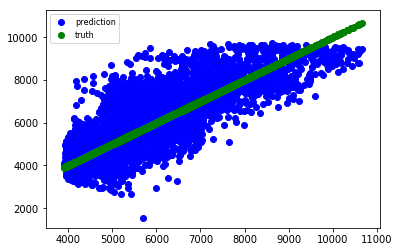

In [81]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))

print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])

print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
# %matplotlib notebook
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()